In [ ]:
import sys

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.feature as ccft
import cartopy.crs as ccrs

import pandas as pd

import json

import data_utils as du

In [2]:
from sklearn.metrics import mean_squared_error 

def skill_metrics(obs, mod):
    
    onne = obs[~np.isnan(obs)]
    mnne = mod[~np.isnan(mod)]
    
    corr = np.corrcoef(onne, mnne)[0, 1]
    rmse = mean_squared_error(onne, mnne, squared=False)
    
    results = [corr, rmse]
    
    return results

In [3]:
init_dir = os.getcwd()

drive_str = f'{init_dir}/cnn/data'

PRYSM_dat = pd.read_csv(f'{drive_str}/prysm_ts2.csv', index_col=0)
fANN_dat = pd.read_csv(f'{drive_str}/10k_fANN3_pred_shuff.csv', index_col=0)
obs_dat = pd.read_excel(f'{drive_str}/obs_ts_1940.xlsx')
dCNN_dat = pd.read_csv(f'{drive_str}/dCNN_311E.csv', index_col=0)
gCNN_dat = pd.read_csv(f'{drive_str}/gCNN_ts.csv')

In [4]:
dCNN_dat[dCNN_dat['name']=='ball_m']

,year,name,lat,lon,X,d18o,d18o_zN,d18o_hat
331,1981,ball_m,-12.6,-69.2,[[[ 2.33879112e-01 2.64368541e-01 2.77443519...,24.140,-0.480769,24.062868
32,1946,ball_m,-12.6,-69.2,[[[ 2.46923241e-01 2.79145374e-01 2.95480098...,23.380,-0.684846,22.379341
322,1980,ball_m,-12.6,-69.2,[[[ 2.80168543e-01 3.01403171e-01 3.14149089...,21.625,-1.156102,22.078730
142,1960,ball_m,-12.6,-69.2,[[[ 3.41054853e-01 3.65071062e-01 3.70305167...,22.295,-0.976193,21.927140
79,1953,ball_m,-12.6,-69.2,[[[ 2.37642731e-01 2.63042019e-01 2.72749278...,22.405,-0.946655,21.654512
...,...,...,...,...,...,...,...,...
133,1959,ball_m,-12.6,-69.2,[[[ 0.32424711 0.3485461 0.35426351]\n [ 0...,23.990,-0.521047,22.854198
106,1956,ball_m,-12.6,-69.2,[[[ 1.19027028e-01 1.47953424e-01 1.55696607...,22.970,-0.794940,21.861578
52,1950,ball_m,-12.6,-69.2,[[[ 1.87070384e-01 2.10279369e-01 2.18711521...,23.910,-0.542529,22.833292
2,1940,ball_m,-12.6,-69.2,[[[ 3.19162106e-01 3.40011117e-01 3.46875095...,22.565,-0.903692,22.177605


In [5]:
pr = PRYSM_dat.reset_index()
# Use the melt function to transform the DataFrame
melted_PRYSM = pd.melt(pr, id_vars=['year'], var_name='name', value_name='PRYSM_d18o')
melted_PRYSM

,year,name,PRYSM_d18o
0,1940,baker_ecu,24.262
1,1941,baker_ecu,23.400
2,1942,baker_ecu,23.685
3,1943,baker_ecu,24.170
4,1944,baker_ecu,24.365
...,...,...,...
776,2006,rodcat_utu,27.203
777,2007,rodcat_utu,27.377
778,2008,rodcat_utu,NaN
779,2009,rodcat_utu,NaN


In [6]:
pz = PRYSM_dat.stack()
pz

year            
1940  baker_ecu     24.262
      brie_sel      21.445
      ball_v        29.993
      ball_m        22.614
      jenkins       23.272
                     ...  
2010  baker_ecu     23.549
      brie_elt      22.302
      brie_sel      22.060
      ortega_jam    25.240
      rodcat_gua    33.851
Length: 657, dtype: float64

In [7]:
def rename(O, N, dft):
    dft[N] = dft[O]
    dft = dft.drop(O, axis=1)
    return dft

dft = dCNN_dat.merge(gCNN_dat, on=['year', 'name']).drop(['d18o_zN','Unnamed: 0'], axis=1)
dft['dCNN_d18o'] = dft['d18o_hat']
dft = dft.drop('d18o_hat', axis=1)
dft = dft.merge(fANN_dat, on=['year', 'name']).drop(['X','lat_x','lon_y', 'd18o_x','d18o_zN','T_zN', 'P_zN', 'Rh_zN', ], axis=1)
dft['fANN_d18o'] = dft['d18o_hat']
dft = dft.drop('d18o_hat', axis=1)
dft =dft.merge(melted_PRYSM, on=['year', 'name'])
dft = rename('d18o_y', 'obs_d18o', dft)

In [8]:
dft[dft['name']=='brie_sel']

,year,name,lon_x,gCNN_d18o,dCNN_d18o,lat_y,T,P,Rh,fANN_d18o,PRYSM_d18o,obs_d18o
15,1970,brie_sel,-66.31,22.556,21.472363,-10.1,298.486572,0.005431,83.387375,22.796776,21.438,19.87
31,1964,brie_sel,-66.31,22.556,21.719498,-10.1,298.333435,0.004573,81.088945,22.288640,21.973,22.13
34,1997,brie_sel,-66.31,22.556,24.196049,-10.1,299.094849,0.005337,82.368537,23.091080,21.469,23.97
41,2005,brie_sel,-66.31,22.556,21.476727,-10.1,298.962860,0.004808,81.832492,22.721123,21.624,20.40
51,1958,brie_sel,-66.31,22.556,21.736599,-10.1,298.771484,0.005608,81.539240,23.129580,21.744,22.39
...,...,...,...,...,...,...,...,...,...,...,...,...
549,1980,brie_sel,-66.31,22.556,21.534964,-10.1,298.589264,0.005000,83.745903,22.568108,21.330,22.26
551,1975,brie_sel,-66.31,22.556,22.463440,-10.1,298.013763,0.004943,84.708633,22.199863,21.306,19.89
570,1942,brie_sel,-66.31,22.556,21.630108,-10.1,297.946136,0.004750,74.934241,22.465385,23.395,21.28
577,1973,brie_sel,-66.31,22.556,21.787746,-10.1,298.229919,0.005989,86.927991,22.859182,20.771,19.99


In [25]:
bs = dft[dft['name']=='brie_sel']


imi = np.argmin(bs.dCNN_d18o)
ima = np.argmax(bs.dCNN_d18o)
bs.iloc[ima]


year                1997
name            brie_sel
lon_x             -66.31
gCNN_d18o         22.556
dCNN_d18o      24.196049
lat_y              -10.1
T             299.094849
P               0.005337
Rh             82.368537
fANN_d18o       23.09108
PRYSM_d18o        21.469
obs_d18o           23.97
Name: 34, dtype: object

In [10]:
# Convert datasets to sets for faster membership checking
set_a = set(fANN_dat.index)
set_b = set(dCNN_dat.index)

# Find missing indices in Dataset A compared to Dataset B
missing_in_a = list(set_b - set_a)

# Find missing indices in Dataset B compared to Dataset A
missing_in_b = list(set_a - set_b)


F = fANN_dat.loc[~fANN_dat.index.isin(missing_in_b)]

F

,year,name,lat,lon,T,P,Rh,d18o,T_zN,P_zN,Rh_zN,d18o_zN,d18o_hat
563,1999,rodcat_gua,-18.28,-69.04,277.300018,0.002907,31.166660,25.932930,-1.046677,-0.490664,-1.045838,0.055548,29.203410
506,1994,ball_v,-22.00,-66.00,282.231598,0.001617,26.933383,30.560000,-0.544602,-1.006965,-1.200092,1.352647,31.357780
558,1999,brie_elt,-10.98,-65.72,298.506775,0.005238,82.835128,21.320000,1.112343,0.442280,0.836889,-1.237588,22.711840
479,1991,rodcat_fsa,-19.06,-69.27,278.498810,0.001807,37.769771,28.067130,-0.924631,-0.930871,-0.805229,0.653825,28.204540
447,1988,rodcat_gua,-18.28,-69.04,277.215302,0.002820,36.168527,30.464710,-1.055302,-0.525184,-0.863576,1.325935,28.741308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,1971,rodcat_gua,-18.28,-69.04,275.697327,0.002091,28.746476,25.907410,-1.209844,-0.817029,-1.134026,0.048394,28.577780
152,1959,jenkins,-12.40,-69.20,297.876892,0.005980,85.346012,21.775000,1.048216,0.739153,0.928382,-1.110038,22.742300
213,1965,ball_m,-12.60,-69.20,298.025543,0.005094,82.011380,24.130000,1.063350,0.384872,0.806873,-0.449865,22.414795
550,1998,ball_v,-22.00,-66.00,282.669769,0.001222,22.569876,31.500000,-0.499993,-1.164783,-1.359092,1.616156,32.061190


In [11]:
# By Name
dft_sort = dft.sort_index().groupby('name', group_keys=True).apply(lambda x: x)

dCNN_dat_sort = dCNN_dat.sort_index().groupby('name', group_keys=True).apply(lambda x: x)
fANN_dat_sort = fANN_dat.sort_index().groupby('name', group_keys=True).apply(lambda x: x)

# Drop rows where the index label is 'baker_ecu'
fds = fANN_dat_sort[~(fANN_dat_sort.index == 'baker_ecu')]

In [12]:
dft_sort.name['ball_m']

1      ball_m
25     ball_m
71     ball_m
76     ball_m
86     ball_m
        ...  
546    ball_m
553    ball_m
562    ball_m
563    ball_m
581    ball_m
Name: name, Length: 65, dtype: object

In [13]:
name='ball_m'
model='fANN'

y_hat = dft.loc[dft['name'] == name][f'{model}_d18o']
y_hat

1      23.386942
25     23.033995
71     23.158989
76     22.761345
86     23.466080
         ...    
546    22.742300
553    22.485640
562    23.527290
563    22.952986
581    22.937850
Name: fANN_d18o, Length: 65, dtype: float64

In [14]:
dft['mCNN_d18o'] = ( dft.gCNN_d18o + dft.dCNN_d18o ) / 2

In [15]:
dft.to_csv('allpreds.csv')

In [16]:
train, val, test = du.train_val_test(dft)
oos = pd.concat((val, test))
oos

,year,name,lon_x,gCNN_d18o,dCNN_d18o,lat_y,T,P,Rh,fANN_d18o,PRYSM_d18o,obs_d18o,mCNN_d18o
497,1971,jenkins,-69.20,23.038,22.498903,-12.40,296.976746,0.006685,85.387911,22.719559,24.112,23.81400,22.768451
498,1984,rodcat_irr,-68.34,30.199,31.418793,-20.43,278.725403,0.001757,35.111119,28.709373,29.813,29.85390,30.808897
499,1965,rodcat_irr,-68.34,30.199,31.629680,-20.43,278.114624,0.000539,22.376855,32.724648,32.991,33.54966,30.914340
500,1948,jenkins,-69.20,23.038,22.350885,-12.40,298.645905,0.003520,76.777263,21.983164,26.493,21.56500,22.694443
501,1993,ball_v,-66.00,30.362,31.479364,-22.00,281.247192,0.001801,27.983854,31.261492,31.006,31.11500,30.920682
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1943,brie_sel,-66.31,22.556,21.544800,-10.10,297.359222,0.005172,83.898250,22.044252,21.678,21.83000,22.050400
493,1954,ball_m,-69.20,23.038,21.842836,-12.60,297.471191,0.006856,85.541953,23.068783,23.002,21.63500,22.440418
494,1970,rodcat_gua,-69.04,28.715,28.506907,-18.28,276.303894,0.001871,30.921177,27.666302,30.673,26.86747,28.610954
495,1994,jenkins,-69.20,23.038,22.361150,-12.40,298.073517,0.006729,85.273745,23.306957,23.535,25.76600,22.699575


In [17]:
dft['obs_d18o']

0      25.197530
1      24.140000
2      23.533333
3      28.930000
4      24.446000
         ...    
581    21.730000
582    31.400000
583    23.292000
584    27.753390
585    29.950000
Name: obs_d18o, Length: 586, dtype: float64

In [18]:
def score_calc(df, grouped=True, write=False, write_n=None, drive_str=None):
    # Check if grouping is needed
    if not grouped:
        df = df.groupby('name', group_keys=True).apply(lambda x: x)

    results = {}  # Dictionary to store results
    
    # Create an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['Site', 'Model', 'RMSE', 'Pearson Correlation'])



    for name in df.name.unique():

        l = ['PRYSM', 'fANN', 'dCNN']

        model_scores = {}  # Dictionary to store scores for each model

        for model in l:
            filtered_df = df.loc[df['name'] == name].dropna(subset=[f'{model}_d18o'])
            # df = filtered_df

            y_hat = df.loc[df['name'] == name][f'{model}_d18o']
            
            y = df.loc[df['name'] == name]['obs_d18o']

            score = skill_metrics(y, y_hat)
            cor = score[0]
            rmse = score[1]
            
            
            
            model_scores[str(model)] = score  # Store the score with the model name as the key
            
            results_df = results_df.append({'Site': name, 'Model': model, 'RMSE': rmse, 'Pearson Correlation': cor}, ignore_index=True)

        results[name] = model_scores  # Store the model scores for this name
        
        # Append results to the results DataFrame
        
        
    if write:
        # Check if drive_str and write_n are provided
        if drive_str is not None and write_n is not None:
            with open(f'{drive_str}/{write_n}.json', 'w') as convert_file:
                json.dump(results, convert_file)

    return results, results_df

In [19]:
def TotalScore(df, subset_name):
    
    results = {}  # Dictionary to store results
    
    # Create an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['Model', 'RMSE', 'Pearson Correlation'])

    l = ['PRYSM', 'fANN', 'dCNN', 'gCNN', 'mCNN']

    for model in l:
        filtered_df = df.dropna(subset=[f'{model}_d18o'])
            # df = filtered_df
        df = filtered_df
            
        y_hat = df[f'{model}_d18o']
            
        y = df['obs_d18o']

        score = skill_metrics(y, y_hat)
        cor = round(score[0], 3)
        rmse = round(score[1], 3)

        results_df = results_df.append({'Model': model, 'RMSE': rmse, 'Pearson Correlation': cor}, ignore_index=True)
    
    # Add a super column heading for the subset
    results_df.insert(0, 'Subset', subset_name)
    return results_df

        
        
    
    
    
    
    
    
# Assuming you have separate DataFrames for training, validation, testing, and overall datasets
training_results = TotalScore(train, 'Training')
validation_results = TotalScore(val, 'Validation')
testing_results = TotalScore(test, 'Testing')
overall_results = TotalScore(dft, 'Overall')
oos_results = TotalScore(oos, 'OutOfSample')

# Combine the results for different subsets into a single DataFrame
all_results = pd.concat([training_results, validation_results, testing_results, overall_results], axis=1)
all_results.insert(0, 'Site', 'Overall')


/var/folders/7s/vw8f9x0j4db6v1gv2xcjh46m0000gn/T/ipykernel_61262/2037775298.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'RMSE': rmse, 'Pearson Correlation': cor}, ignore_index=True)
/var/folders/7s/vw8f9x0j4db6v1gv2xcjh46m0000gn/T/ipykernel_61262/2037775298.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'RMSE': rmse, 'Pearson Correlation': cor}, ignore_index=True)
/var/folders/7s/vw8f9x0j4db6v1gv2xcjh46m0000gn/T/ipykernel_61262/2037775298.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'RMSE': rmse, 'Pearson Correlation': cor}, ignore_index=True)
/var/folders/7s/

In [178]:
all_results

,Site,Subset,Model,RMSE,Pearson Correlation,Subset,Model,RMSE,Pearson Correlation,Subset,Model,RMSE,Pearson Correlation,Subset,Model,RMSE,Pearson Correlation
0,Overall,Training,PRYSM,1.865,0.875,Validation,PRYSM,1.906,0.893,Testing,PRYSM,1.695,0.889,Overall,PRYSM,1.838,0.880
1,Overall,Training,fANN,1.701,0.890,Validation,fANN,1.821,0.903,Testing,fANN,1.559,0.902,Overall,fANN,1.693,0.893
2,Overall,Training,dCNN,0.864,0.972,Validation,dCNN,1.707,0.914,Testing,dCNN,1.575,0.908,Overall,dCNN,1.192,0.948
3,Overall,Training,gCNN,1.641,0.902,Validation,gCNN,1.775,0.927,Testing,gCNN,1.559,0.908,Overall,gCNN,1.646,0.906
4,Overall,Training,mCNN,1.154,0.953,Validation,mCNN,1.652,0.927,Testing,mCNN,1.448,0.918,Overall,mCNN,1.303,0.941


In [ ]:
# Create an empty DataFrame to store results for all sites
all_site_results = pd.DataFrame(columns=['Sample Site', 'Subset', 'Model', 'RMSE', 'Pearson Correlation'])

# List of sample sites
sample_sites = df['Site'].unique()

# Iterate over each sample site
for site in sample_sites:
    site_df = df[df['Site'] == site]
    
    # Calculate scores for the site and add them to the results DataFrame
    site_results = TotalScore(site_df, f'Site {site}')
    all_site_results = pd.concat([all_site_results, site_results], ignore_index=True)

# Calculate scores for the entire dataset and add them to the top
overall_results = TotalScore(df, 'Overall')
all_site_results = pd.concat([overall_results, all_site_results], ignore_index=True)

# Print or analyze the combined results
print(all_site_results)

In [63]:
import warnings 
    
    # To suppress all warnings
warnings.filterwarnings('ignore')

def TimeSeries(name=None, df=dft):
    
    if name:
        # Select Site
        df = df.loc[df['name'] == name]
        # Split
        tr, va, te = du.train_val_test(df)
        #
        training_results = TotalScore(tr, 'Training')
        validation_results = TotalScore(va, 'Validation')
        testing_results = TotalScore(te, 'Testing')
        overall_results = TotalScore(df, 'Overall')
        
        # Combine the results for different subsets into a single DataFrame
    all_results = pd.concat([training_results, validation_results, testing_results, overall_results],  axis=1)
    
    all_results.insert(0, 'Site', name)
    
    return(all_results)


# Create an empty DataFrame to store results for all sites
all_site_results = pd.DataFrame(columns=['Site', 'Subset', 'Model', 'RMSE', 'Pearson Correlation', 'Subset', 'Model', 'RMSE', 'Pearson Correlation', 'Subset', 'Model', 'RMSE', 'Pearson Correlation', 'Subset', 'Model', 'RMSE', 'Pearson Correlation'])

# List of sample sites
sample_sites = dft.name.unique()

# Iterate over each sample site
for site in sample_sites:
    
    o = TimeSeries(site)
    all_site_results = pd.concat((all_site_results, o))
   
all_site_results = pd.concat((all_site_results, all_results))

In [180]:
all_site_results.to_csv('sitescores2.csv')

In [183]:
os.getcwd()

'/Users/benjaminmellor/GEOGM00XX_DISS'

In [65]:


# a, b = score_calc(dft)

_, x = score_calc(oos)
x

,Site,Model,RMSE,Pearson Correlation
0,jenkins,PRYSM,1.844920,-0.354682
1,jenkins,fANN,1.482762,0.585663
2,jenkins,dCNN,1.708498,0.205441
3,rodcat_irr,PRYSM,1.378936,0.388334
4,rodcat_irr,fANN,1.334862,0.562611
5,rodcat_irr,dCNN,1.452257,0.037925
6,ball_v,PRYSM,1.324032,0.237605
7,ball_v,fANN,1.321293,0.060567
8,ball_v,dCNN,1.248481,0.056045
9,rodcat_utu,PRYSM,2.396615,-0.111802


In [59]:
# Assuming you have a DataFrame 'results_df' with the results for each site and model
def compare(df):
    b=df
# Create an empty list to store the results
    site_comparison_results = []

# Iterate through each site
    for site in b['Site'].unique():
        site_data = b[b['Site'] == site]

    # Find the rows corresponding to PRYSM and CNN (dCNN)
        prysm_row = site_data[site_data['Model'] == 'PRYSM']
        cnn_row = site_data[site_data['Model'] == 'dCNN']
    
    # Extract RMSE and Pearson correlation values for PRYSM and CNN
        prysm_rmse = prysm_row['RMSE'].values[0]
        cnn_rmse = cnn_row['RMSE'].values[0]
        prysm_corr = prysm_row['Pearson Correlation'].values[0]
        cnn_corr = cnn_row['Pearson Correlation'].values[0]
    
    # Compare RMSE and Pearson correlation to determine which model is better
        if prysm_rmse < cnn_rmse and prysm_corr > cnn_corr:
            result = 'PRYSM > CNN'
        elif cnn_rmse < prysm_rmse and cnn_corr > prysm_corr:
            result = 'CNN > PRYSM'
        else:
            result = 'CNN = PRYSM'

    # Append the result to the list
        site_comparison_results.append({'Site': site, 'Comparison Result': result})

# Convert the list of results to a DataFrame
    comparison_df = pd.DataFrame(site_comparison_results)

# Print or analyze the comparison results
    print(comparison_df)

In [60]:
def score_pl(df):
    _, s = score_calc(df)
    o = compare(s)
    return o
    
score_pl(oos)

         Site Comparison Result
0     jenkins       CNN > PRYSM
1  rodcat_irr       PRYSM > CNN
2      ball_v       CNN = PRYSM
3  rodcat_utu       CNN > PRYSM
4      ball_m       PRYSM > CNN
5    brie_elt       CNN > PRYSM
6  rodcat_gua       CNN > PRYSM
7  ortega_jam       CNN > PRYSM
8    brie_sel       CNN > PRYSM
9  rodcat_fsa       CNN = PRYSM


/var/folders/7s/vw8f9x0j4db6v1gv2xcjh46m0000gn/T/ipykernel_61262/992207205.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Site': name, 'Model': model, 'RMSE': rmse, 'Pearson Correlation': cor}, ignore_index=True)
/var/folders/7s/vw8f9x0j4db6v1gv2xcjh46m0000gn/T/ipykernel_61262/992207205.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Site': name, 'Model': model, 'RMSE': rmse, 'Pearson Correlation': cor}, ignore_index=True)
/var/folders/7s/vw8f9x0j4db6v1gv2xcjh46m0000gn/T/ipykernel_61262/992207205.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Site': name, 'Model': model, 'RMSE': rmse, 'Pearson Correlation': co

In [389]:
a

In [16]:
names = sorted(dCNN_dat.name.unique())
names

['ball_m',
 'ball_v',
 'brie_elt',
 'brie_sel',
 'jenkins',
 'ortega_jam',
 'rodcat_fsa',
 'rodcat_gua',
 'rodcat_irr',
 'rodcat_utu']

In [54]:
from scipy.stats import linregress

def plot_scatter(name, ax, df=dft, pt=False):
    
    # Select Site
    df = df.loc[df['name'] == name]
    

    y = df.obs_d18o
    y_LMM = df.PRYSM_d18o
    
    y_CNN = df.dCNN_d18o
    y_CNNb = df.gCNN_d18o
    x_max = np.max(y)
    x_min = np.min(y)
    
    y_max = x_max
    y_min = x_min


    
    # Calculate regression lines and obtain slope and p-value
    prysm_slope, prysm_intercept, prysm_r_value, prysm_p_value, _ = linregress(y, y_LMM)
    dcnn_slope, dcnn_intercept, dcnn_r_value, dcnn_p_value, _ = linregress(y, y_CNN)

    
    
    ax.scatter(y, y_LMM, facecolor='none', edgecolor='r', alpha=.7)
    ax.scatter(y, y_CNN, facecolor='none', edgecolor='b', alpha=.7)
    ax.scatter(y, y_CNNb, facecolor='none', edgecolor='g', alpha=.7)
    
    ax.plot([x_min, x_max], [y_min, y_max], color='black', linestyle='--', linewidth=1)
    
        # Add regression lines for PRYSM and dCNN
    ax.plot(np.unique(y), np.poly1d(np.polyfit(y, y_LMM, 1))(np.unique(y)), color='k', linestyle='-', linewidth=1, label=f'm={prysm_slope:.3f}, p={prysm_p_value:.3f}')
    ax.plot(np.unique(y), np.poly1d(np.polyfit(y, y_CNN, 1))(np.unique(y)), color='blue', linestyle='-', linewidth=1, label=f'm={dcnn_slope:.3f}, p={dcnn_p_value:.3f}')

    ax.legend()
    #ax.plot([x_min, x_max], [LMMy_min, LMMy_max], c='r', linestyle = '-', linewidth = .5)
    #ax.plot([x_min, x_max], [CNNy_min, CNNy_max], c='b', linestyle = '-', linewidth = .5)
    

In [55]:
plt.rcParams["figure.figsize"] = 18,10


In [56]:
names

['ball_m',
 'ball_v',
 'brie_elt',
 'brie_sel',
 'jenkins',
 'ortega_jam',
 'rodcat_fsa',
 'rodcat_gua',
 'rodcat_irr',
 'rodcat_utu']

ball_m
ball_v
brie_elt
brie_sel
jenkins
ortega_jam
rodcat_fsa
rodcat_gua
rodcat_irr
rodcat_utu


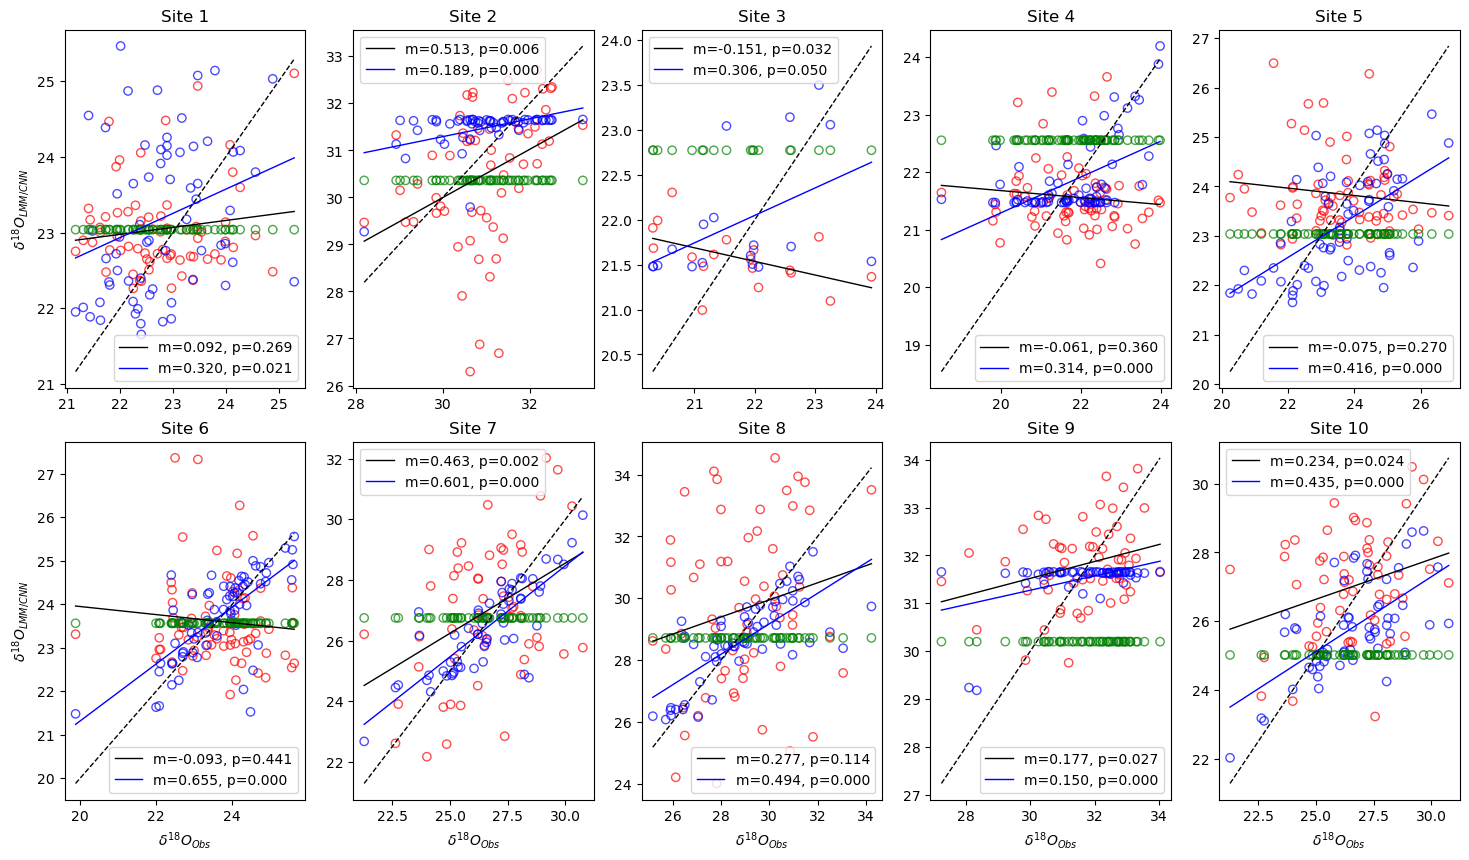

In [57]:
fig, axs = plt.subplots(2, 5)

ylab = r'$\delta^{18}O_{LMM/CNN}$'
xlab = r'$\delta^{18}O_{Obs}$'


for i, ax in enumerate(axs.flat):
    
        
        name = names[i]

        ax.set_title(f'Site {i+1}')
        
        
        print(name)
        
        
        if i > 4:
            ax.set_xlabel(xlab)

        plot_scatter(name, ax)
      
        
axs[0,0].set_ylabel(ylab)
axs[1,0].set_ylabel(ylab)

plt.subplots_adjust(wspace = 0.2, hspace=.15)

# plt.savefig('scatters2.png')

In [370]:
def f(name, df = dft):
    df = df.loc[df['name'] == name]
    y = df.obs_d18o
    print(y)
    
f('')

In [47]:
def plot_metscat(I, ax, df = dft):
    
    ax.scatter(dft[I], (dft.PRYSM_d18o-dft.obs_d18o), facecolor='none', edgecolor='r', alpha=.6, label = 'LMM')    
    ax.scatter(dft[I], (dft.gCNN_d18o-dft.obs_d18o),  facecolor='none', edgecolor='orange', alpha=.3, label = 'CNNa')
    ax.scatter(dft[I], (dft.fANN_d18o-dft.obs_d18o), facecolor='none', edgecolor='g', alpha=.3, label = 'ANN')
    ax.scatter(dft[I], (dft.dCNN_d18o-dft.obs_d18o), facecolor='none', edgecolor='b', alpha=.3, label = 'CNNb')
    x_min = dft[I].min()
    x_max = dft[I].max()
    ax.plot((x_min, x_max), (0,0), c='k', linewidth=.5)

In [48]:
plt.rcParams["figure.figsize"] = 8,8

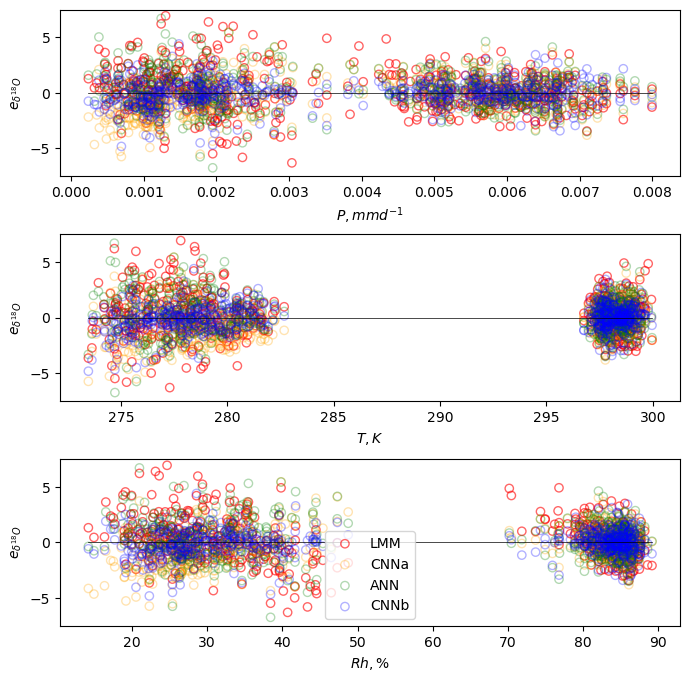

In [51]:


fig, axs = plt.subplots(3, 1)

plot_metscat('Rh', axs[2])
plot_metscat('P', axs[0])
plot_metscat('T', axs[1])

for ax in axs.flat:
    ax.set_ylim(-7.5, 7.5)
    ax.set_ylabel(r'$e_{\delta^{18}O}$')

axs[0].set_xlabel(r'$P, mm d^{-1}$')
axs[1].set_xlabel(r'$T, K$')
axs[2].set_xlabel(r'$Rh,$%')
axs[2].legend()

plt.subplots_adjust(wspace = 0.2, hspace=.35)

plt.savefig('metres.png')

In [45]:
def mod_residual(mod, ax, df = dft, **args):
    y_hat = dft[f'{mod}_d18o']
    y = dft.obs_d18o
    
    e = y-y_hat
    
    ax.scatter(y_hat, e, **args)
    
    x_max = np.max(y_hat)
    x_min = np.min(y_hat)

    ax.plot((x_min, x_max), (0,0), c='k', linewidth=.5)
    
    # Calculate regression lines and obtain slope and p-value
    slope, intercept, r_value, p_value, _ = linregress(y_hat, e)
    print(p_value)
    ax.plot(np.unique(y_hat), np.poly1d(np.polyfit(y_hat, e, 1))(np.unique(y_hat)), color='r', linestyle='-', linewidth=1 , label=f'$y = {slope:.3f}x + {intercept:.3f}, r^2={r_value:.3f},$\n$p={p_value:.3f}$') #, p={p_value.3f}$')

plt.rcParams["figure.figsize"] = 9,8

5.5079195448172116e-11
0.054261199968991314
0.34720096620082175
3.662345003542201e-09


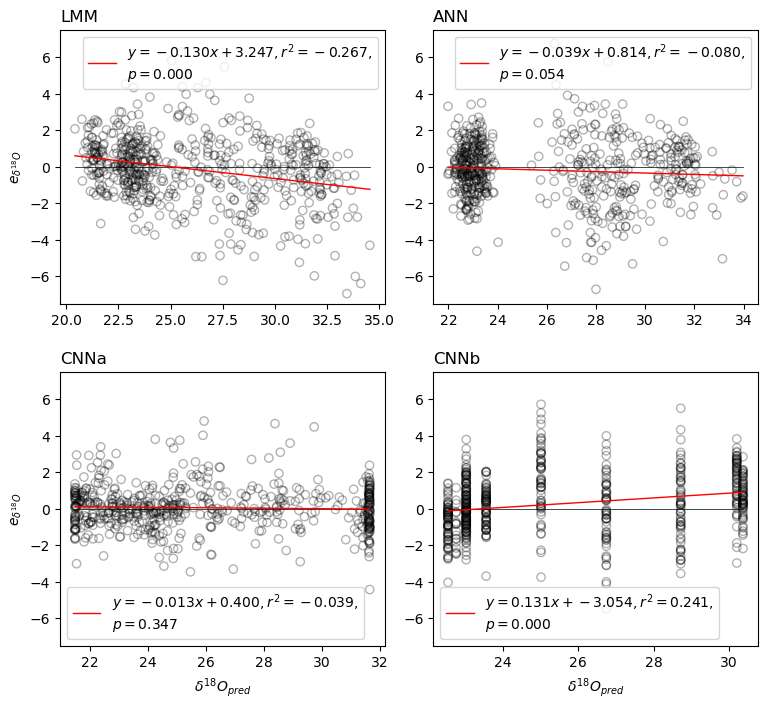

In [47]:
fig, axs = plt.subplots(2, 2)
mod_residual('PRYSM', ax=axs[0,0], facecolor='none', edgecolor='k', alpha=.3)
mod_residual('fANN', ax=axs[0,1], facecolor='none', edgecolor='k', alpha=.3)
mod_residual('dCNN', ax=axs[1,0], facecolor='none', edgecolor='k', alpha=.3)
mod_residual('gCNN', ax=axs[1,1], facecolor='none', edgecolor='k', alpha=.3)
# mod_residual('mCNN', ax=axs[2,1], facecolor='none', edgecolor='k', alpha=.3)


for ax in axs.flat:
    ax.set_ylim(-7.5, 7.5)
    ax.legend()
    
axs[0,0].set_ylabel(r'$e_{\delta^{18}O}$')
axs[1,0].set_ylabel(r'$e_{\delta^{18}O}$')
# axs[0,0].set_ylabel(r'$e_{\delta^{18}O}$')
    
axs[1,0].set_xlabel(r'$\delta^{18}O_{pred}$')
axs[1,1].set_xlabel(r'$\delta^{18}O_{pred}$')

axs[0,0].set_title('LMM', loc = "left")
axs[0,1].set_title('ANN', loc = "left")
axs[1,0].set_title('CNNa', loc = "left")
axs[1,1].set_title('CNNb', loc = "left")

    
plt.subplots_adjust(wspace = 0.15, hspace=.25)

plt.savefig('qqplots2.png')

In [26]:
dft.to_csv('dft.csv')

In [28]:
dft.iloc[100]

year                1950
name              ball_v
lon_x              -66.0
gCNN_d18o         30.362
dCNN_d18o      31.629883
lat_y              -22.0
T             279.658875
P               0.002143
Rh             38.103691
fANN_d18o      29.473785
PRYSM_d18o        28.312
obs_d18o          31.085
Name: 100, dtype: object

In [10]:
# Grouping by multiple names in the 'Name' column
names_to_group_by = ['brie_sel', 'brie_elt', 'ball_m', 'jenkins', 'ortega_jam']
names_to_group_by2 = ['rodcat_irr', 'rodcat_utu', 'ball_v', 'rodcat_fsa', 'rodcat_gua']
Amazon = dft[dft['name'].isin(names_to_group_by)].groupby('name')
Alti = dft[dft['name'].isin(names_to_group_by2)].groupby('name')

In [37]:
# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Name', 'Rh_mean', 'Rh_var', 'T_mean', 'T_var', 'P_mean', 'P_var'])

names = sorted(dft['name'].unique())  # Get unique names from the 'name' column

for n in names:
    d = dft[dft['name'] == n]
    rhm = d['Rh'].mean()
    rhs = d['Rh'].var()
    tm = d['T'].mean() - 273.15
    ts = d['T'].var()
    pm = d['P'].mean()
    ps = d['P'].var()
    
    # Create a new row with the computed values
    row = pd.DataFrame({'Name': [n], 'Rh_mean': [rhm], 'Rh_var': [rhs], 'T_mean': [tm], 'T_var': [ts], 'P_mean': [pm], 'P_var': [ps]})
    
    # Concatenate the new row to the result DataFrame
    result_df = pd.concat([result_df, row], ignore_index=True)

# Print the result DataFrame
print(result_df)

result_df.to_csv('a.csv')

         Name    Rh_mean     Rh_var     T_mean     T_var    P_mean  \
0      ball_m  85.003399   5.076554  24.583041  0.135181  0.006370   
1      ball_v  29.976808  28.148948   7.669410  0.641419  0.001817   
2    brie_elt  82.534915   3.318347  25.699470  0.108800  0.005072   
3    brie_sel  82.766454   9.435055  25.349334  0.196990  0.005130   
4     jenkins  84.936214   5.075111  24.608067  0.151831  0.006376   
5  ortega_jam  82.507487  12.133378  25.743578  0.196959  0.005808   
6  rodcat_fsa  37.781167  24.437766   4.935704  0.583958  0.001697   
7  rodcat_gua  32.808966  32.311464   3.549968  0.667249  0.002395   
8  rodcat_irr  26.871022  12.510655   5.840642  0.581541  0.000899   
9  rodcat_utu  22.024929  12.960756   1.903012  0.535784  0.001002   

          P_var  
0  6.783849e-07  
1  6.963603e-08  
2  2.334580e-07  
3  3.641459e-07  
4  6.592673e-07  
5  4.181347e-07  
6  2.204861e-07  
7  2.790348e-07  
8  1.021296e-07  
9  9.098217e-08  


In [43]:
dft.obs_d18o.var()# - 273.15

13.868818015812337

In [42]:
dft.obs_d18o.mean()

25.930425307167237